# Data Exploration and Cleaning of the dataset (V1)

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp WELFake_Dataset.csv /content/drive/MyDrive/WELFake_Dataset.csv

cp: cannot stat 'WELFake_Dataset.csv': No such file or directory


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a44ebcf16fae0e497ebeb492fd087a41534310d6c51ffadac3c844c64deae8c3
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
import pandas as pd
import numpy as np
import re # regex module
import unicodedata # handling unicoded text
from langdetect import detect_langs, DetectorFactory

df = pd.read_csv("/content/drive/MyDrive/WELFake_Dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# Confirming Dataset Scale:

In [ ]:
df.shape

(72134, 4)

In [ ]:
df.columns # columns [gonna be dropping column "Unnamed: 0" as it is the index and serves no value.]

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [ ]:
df.info() # index column can be dropped safely.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
df.dtypes

,0
Unnamed: 0,int64
title,object
text,object
label,int64


In [ ]:
df.nunique() # unique values per column

,0
Unnamed: 0,72134
title,62347
text,62718
label,2


^ key insights from nunique();

index columns has no unique values -> safe to drop
title has 62347 unique values -> over 10k titles are repeated (possible duplicates, or reused headlines, etc.)
text, again same as title, may have to drop "exact" duplicates.
label -> binary classification column (0, 1).

# Handling Missing Values and Duplicates:

In [ ]:
df.isna().sum() # check missing values out of ~72k data

,0
Unnamed: 0,0
title,558
text,39
label,0


In [ ]:
df.isna().sum()*100 # percentage based

,0
Unnamed: 0,0
title,55800
text,3900
label,0


key insights: title; 558 missing values out of ~72k (almost ~0.77%)

text; 39 missing values out of ~72k (almost ~0.05%)

label and index at [0] -> expected.

2. Checking duplicates:

In [ ]:
df.duplicated().sum() # full row duplicates

np.int64(0)

In [ ]:
df.duplicated(subset=['title','text']).sum()

np.int64(8456)

8456 out of 72134 ((~~11.7%))are repeated articles, possibly with the same headline + text

**Dropping Column "Unnamed: 0":**


In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.columns # check if its gone

Index(['title', 'text', 'label'], dtype='object')

3. Handling missing values:

In [ ]:
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

In [ ]:
df.isna().sum() # rechecking missing values

,0
title,0
text,0
label,0


In [ ]:
df[df['title'] == ''].head() # titles that previously had "NaN" value -> now ''

,title,text,label
1,,Did they post their votes for Hillary already?,1
43,,True. Hillary needs a distraction and what bet...,1
162,,All eyes on Electoral delegates. The People kn...,1
185,,Cool,1
269,,A leading US senator: US Supporting War in Syr...,1


In [ ]:
df[df['text'] == ''].head() # text that previously had "NaN" value -> now ''

,title,text,label
2457,Après le succès de « Mariés au premier regard ...,,1
3534,Elections US : les premières estimations donne...,,1
3709,110% des Américains assurent qu’ils continuero...,,1
5612,Des millions d’Américains recherchent massivem...,,1
6270,Vladimir Poutine est élu 45e Président des Eta...,,1


Some titles/texts are in other languages (e.g., French).

(need insights on this)

4. Dropping title+text duplicate pairs:

In [ ]:
df = df.drop_duplicates(subset=['title','text']).reset_index(drop=True) # dropping duplicates ~8k

In [ ]:
print("Dataset shape after dropping ~8k duplicates:", df.shape)

Dataset shape after dropping ~8k duplicates: (63678, 3)


# Final Sanity Check:

In [ ]:
print("Missing values:\n", df.isna().sum()) # to confirm no missing values

Missing values:
 title    0
text     0
label    0
dtype: int64


In [ ]:
print("Remaining duplicates:", df.duplicated(subset=['title','text']).sum()) # to confirm no duplicate on title+text still remain

Remaining duplicates: 0


In [ ]:
print(df.columns) # to re-check columns after cleaning

Index(['title', 'text', 'label'], dtype='object')


In [ ]:
print("Dataset shape is:\n", df.shape)

Dataset shape is:
 (63678, 3)


# Creating a combined text field (explained below):

In [ ]:
df['full_text'] = (df['title'] + " " + df['text']).str.strip()

Combining title and text into a single 'full_text' column.

---



This ensures each article has one text representation for preprocessing -> feeding them seperately could complicate things.


---


Titles often contain important contextual or sensational cues -> so merging improves classification performance.

1. Confirming new full_text column:




In [ ]:
df[['title', 'text', 'full_text']].head(5) # this shows ORIGINAL title, and text and NEW combined column

,title,text,full_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,,Did they post their votes for Hillary already?,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",SATAN 2: Russia unvelis an image of its terrif...


In [ ]:
(df['full_text'] == '').sum() # double check for any missing rows

np.int64(0)

In [ ]:
df.sample(3)[['title','text','full_text']] # making sure that title and text were concatenated correctly.

,title,text,full_text
58664,South Korea spy agency sees signs of planned n...,SEOUL (Reuters) - North Korea may be planning ...,South Korea spy agency sees signs of planned n...
7712,Donald Trump’s success reveals a frightening w...,As the Constitutional Convention of 1787 ended...,Donald Trump’s success reveals a frightening w...
16567,Police: Ohio Woman Raped Four-Year-Old,An Ohio woman allegedly raped a on January ...,Police: Ohio Woman Raped Four-Year-Old An Ohio...


In [ ]:
'full_text' in df.columns

True

In [ ]:
for i in [0, 100, 500]:
    print(f"Row {i}:\n", df.loc[i, 'full_text'], "\n")
    # to display without colab "truncating" the full sentence in 'full_text'

Row 0:
 LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO] No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white peopl

# Cleaning function for text (dealing with noise):

In [ ]:
def clean_text(s):
    s = str(s).lower()                           # lowercase
    s = unicodedata.normalize("NFKD", s)         # normalize weird unicode
    s = re.sub(r'[^a-z0-9\s]', ' ', s)              # keep only letters + spaces
    s = re.sub(r'\s+', ' ', s).strip()           # remove extra spaces
    return s

df['clean_text'] = df['full_text'].apply(clean_text)

In [ ]:
df[['full_text', 'clean_text']].sample(5) # spot check

,full_text,clean_text
20470,SLICK SCAM: John Kerry Warns Global Warming Wi...,slick scam john kerry warns global warming wil...
9734,Honduran opposition says will formally challen...,honduran opposition says will formally challen...
18117,Madman Merkel Demands the Internet Publicly Re...,madman merkel demands the internet publicly re...
25103,No cause to fire special counsel Mueller: depu...,no cause to fire special counsel mueller deput...
4461,Both parties want to craft populist messages f...,both parties want to craft populist messages f...


Summary: Imported + loaded dataset.

Inspected structure (shape, info, nunique, dtypes).

Handled missing values (title, text).

Dropped useless column (Unnamed: 0).

Dropped duplicates (title+text).

Confirm dataset is clean (no NaN, no duplicates).

Create full_text column = title + text.

Removed noise from the dataset

Save/export cleaned dataset for the team.

# Dropping/Filtering other languages:

In [ ]:
# langdetect -> tried to use langid, dropped almost every column from the dataset (72k -> dropped to 41)
DetectorFactory.seed = 0  # deterministic

In [ ]:
import pandas as pd
import numpy as np
import re # regex module
import unicodedata # handling unicoded text
from langdetect import detect_langs, DetectorFactory

def is_confident_english(text, thr=0.90):  # function to filter out other languages other than english
    try:
        for cand in detect_langs(str(text)):
            if cand.lang == 'en' and cand.prob >= thr:
                return True
        return False
    except:
        return False

# Load the dataframe if it's not already loaded
if 'df' not in locals() and 'df' not in globals():
    df = pd.read_csv("/content/drive/MyDrive/WELFake_Dataset.csv")

# Ensure 'Unnamed: 0' is dropped and handle missing values
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

# Create 'full_text' column
df['full_text'] = (df['title'] + " " + df['text']).str.strip()

# Create 'clean_text' column by applying the cleaning function
def clean_text(s):
    s = str(s).lower()                           # lowercase
    s = unicodedata.normalize("NFKD", s)         # normalize weird unicode
    s = re.sub(r'[^a-z0-9\s]', ' ', s)              # keep only letters + spaces
    s = re.sub(r'\s+', ' ', s).strip()           # remove extra spaces
    return s

df['clean_text'] = df['full_text'].apply(clean_text)


before = df.shape[0]
df = df[df['clean_text'].apply(is_confident_english)].reset_index(drop=True)
after = df.shape[0]
print(f"Kept English rows: {after} / {before} ({after/before:.1%})")

Kept English rows: 63052 / 63678 (99.0%)


In [ ]:
df.head() # re-checking scaling of dataset after filtering

NameError: name 'df' is not defined

In [ ]:
df.shape

In [ ]:
df.to_csv("cleaned_fake_news.csv", index=False)

In [ ]:
df.to_csv("cleaned_fake_news_english.csv", index=False) #english

In [ ]:
from google.colab import files
files.download("cleaned_fake_news.csv")

In [ ]:
from google.colab import files
files.download("cleaned_fake_news_english.csv") #english

In [ ]:
df.to_csv("/content/drive/MyDrive/cleaned_fake_news.csv", index=False)

In [ ]:
df.to_csv("/content/drive/MyDrive/cleaned_fake_news_english.csv", index=False) #english

# Validating and checking (before vs. after):

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
raw_text = " ".join(df['full_text'].sample(2000, random_state=42))
wc_raw = WordCloud(width=800, height=400, background_color='white').generate(raw_text) # raw text, uncleaned

In [ ]:
clean_text = " ".join(df['clean_text'].sample(2000, random_state=42))
wc_clean = WordCloud(width=800, height=400, background_color='white').generate(clean_text) # cleaned text

In [ ]:
plt.figure(figsize=(16,8)) # plotting

In [ ]:
plt.subplot(1,2,1)
plt.imshow(wc_raw, interpolation='bilinear')
plt.title("Before Cleaning", fontsize=16)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wc_clean, interpolation='bilinear')
plt.title("After Cleaning", fontsize=16)
plt.axis('off')

plt.show()

# to reload later

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/cleaned_fake_news.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/cleaned_fake_news.csv'

From here, Raid, I'm gonna clean the text more by removing stopwords, also stemming

In [ ]:
df.isna().sum()

43 missing values in clean_text so am gonna drop it

In [ ]:
df = df.dropna(subset=['clean_text'])

In [ ]:
df.isna().sum()

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(s):
    words = [w for w in s.split() if w not in stop_words]  # remove stopwords
    words = [stemmer.stem(w) for w in words]  # stemming
    return " ".join(words)

df['clean_text_v2'] = df['clean_text'].apply(clean_text)


here i add a new column same like clean_text but after stemming and removing stopwords it will help in ML track , but for BERT track we will use clean_text

In [ ]:
df[['clean_text', 'clean_text_v2']].sample(5) # spot check

In [ ]:
df.rename(columns={'clean_text_v2': 'stemmed_text'}, inplace=True)

In [ ]:
df.info()

In [ ]:
df['stemmed_text'].sample(5) # spot check

In [ ]:
df['label'].value_counts()

The Difference between fake and real is 34791-28844 = 5947

In [ ]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color=['tomato','skyblue'])
plt.title("Distribution of Real vs Fake News")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0,1], ['Fake', 'Real'], rotation=0)
plt.show()


In [ ]:
# df.drop("word_count_clean", axis=1, inplace=True)

In [ ]:
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

Word count for clean_text


In [ ]:
df[['clean_text','word_count']].sample(5)

In [ ]:
df['word_count'].describe()

In [ ]:
df.rename(columns={'word_count': 'word_count_clean'}, inplace=True)

In [ ]:
df.info()

In [ ]:
df.to_csv("/content/drive/MyDrive/cleaned_fake_news_v3.csv", index=False)

# to reload later

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/cleaned_fake_news_v3.csv")
df.head()

,title,text,label,full_text,clean_text,stemmed_text,word_count_clean
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement on high alert following threat...,law enforc high alert follow threat cop white ...,925
1,NaN,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,did they post their votes for hillary already,post vote hillari alreadi,8
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obama s attorney general says mos...,unbeliev obama attorney gener say charlott rio...,54
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raised hindu uses story of christ...,bobbi jindal rais hindu use stori christian co...,1348
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,satan russia unvelis an image of its terrifyin...,satan russia unv imag terrifi new supernuk wes...,327


# Feature Extraction


for tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['stemmed_text'])

In [ ]:
print("TF-IDF Vocabulary Size:", len(tfidf.vocabulary_))
print("TF-IDF Matrix Shape:", X_tfidf.shape)

feature_array = np.array(tfidf.get_feature_names_out())
tfidf_sorting = np.argsort(X_tfidf.toarray()).flatten()[::-1]
top_words = feature_array[tfidf_sorting[:10]]
print("Top TF-IDF Words:", top_words)

TF-IDF Vocabulary Size: 5000
TF-IDF Matrix Shape: (63052, 5000)
Top TF-IDF Words: ['pena' 'nieto' 'mexico' 'slim' 'mexican' 'trump' 'uniti' 'unpopular'
 'wall' 'leader']


Word embeddings

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

In [ ]:
from gensim.models import Word2Vec

sentences = [row.split() for row in df['clean_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Example: get embedding of one word
print(w2v_model.wv['news'])

[ 0.42782837 -2.1264198  -2.5861042   0.6397219   1.8631823   0.9290322
  2.788548   -0.94953537 -1.9636413   3.8459291   1.0367242  -1.1267409
 -0.8227971  -0.41615075 -1.3114057   1.0819042   1.5083746  -4.120829
 -2.44842    -2.387024   -0.12070654  1.2739869   1.5039302  -1.0522778
 -0.4090489   2.8844728   1.3640709   0.35009626  1.0457982   1.0087587
 -2.8184502   3.8957903  -1.7991028  -0.5075234  -0.6855519   0.22187614
  3.0473428  -0.64162815  0.41159534 -0.22285722  3.7222607  -0.6675146
 -3.4278877  -0.864085   -1.6023484   0.32484636 -1.5297816   0.6889326
 -0.8852874   0.20346718  1.9309962  -3.8674345  -1.126321    1.6637018
 -2.463365   -1.8082016   2.1323254   5.7864413  -1.2809367  -4.0517983
  4.400731   -1.5406739  -1.4457831   0.9611108  -3.388941   -3.7624218
 -1.707505   -3.2418246  -0.40242705  1.2085394   0.7057867  -3.0106528
  1.4146123  -3.7772367  -0.9793962  -2.42845     0.7786743  -3.107173
  3.5847402  -0.60157794 -3.7930384  -0.03411517  0.5263511   0.9

In [ ]:
print("Word2Vec Vocabulary Size:", len(w2v_model.wv))
print("Word2Vec Embedding Dimensions:", w2v_model.vector_size)

print("Most similar to 'news':", w2v_model.wv.most_similar("news", topn=5))

Word2Vec Vocabulary Size: 107582
Word2Vec Embedding Dimensions: 100
Most similar to 'news': [('newswatch', 0.6800832152366638), ('searchlight', 0.6705904006958008), ('newshere', 0.6357621550559998), ('dchere', 0.6213675737380981), ('vicente', 0.6164496541023254)]


#Logistic Regression

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/cleaned_fake_news_v3.csv")


Accuracy: 0.9486955832209976
Precision: 0.9403596225743279
Recall: 0.9442259563818377
F1 Score: 0.9422888234769423

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      7017
           1       0.94      0.94      0.94      5594

    accuracy                           0.95     12611
   macro avg       0.95      0.95      0.95     12611
weighted avg       0.95      0.95      0.95     12611



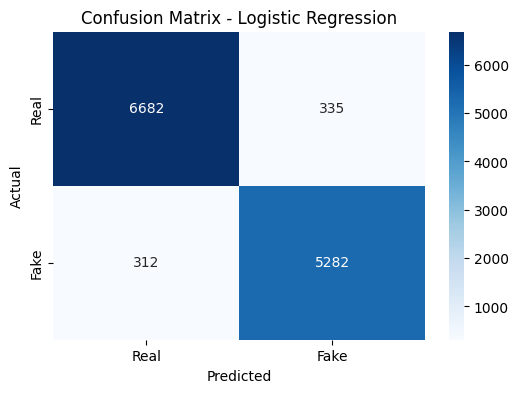

In [ ]:
# --- Logistic Regression Model for Fake News Detection ---

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Combine title and text (if both available) for better representation
df['content'] = df['title'].astype(str) + " " + df['text'].astype(str)

# Features and target
X = df['content']
y = df['label']   # assuming the dataset has a "label" column (1=fake, 0=real)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = vectorizer.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


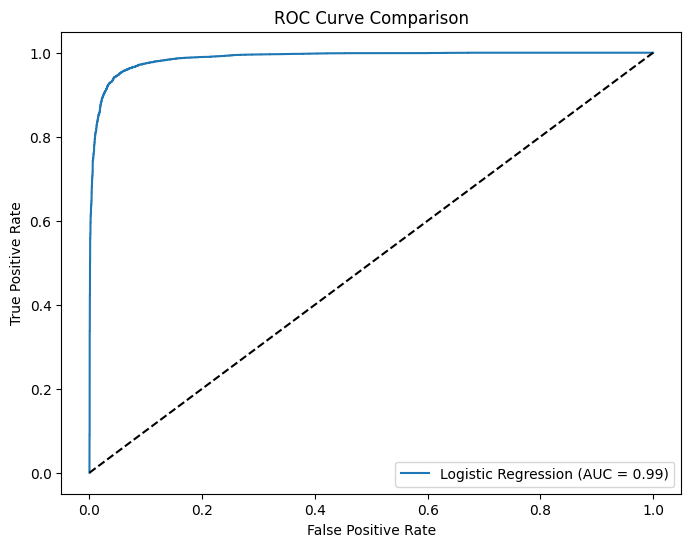

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Logistic Regression - ROC Curve
y_prob_log = log_reg.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

#Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# SVM

**SVM**

Accuracy: 0.9520260090397272
Precision: 0.9466427931960609
Recall: 0.9451197711834108
F1 Score: 0.9458806691117273

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      7017
           1       0.95      0.95      0.95      5594

    accuracy                           0.95     12611
   macro avg       0.95      0.95      0.95     12611
weighted avg       0.95      0.95      0.95     12611



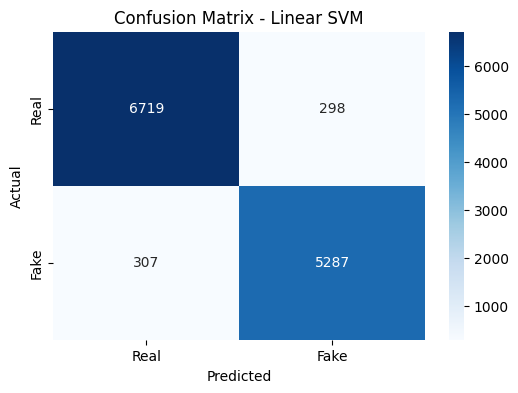

F1 scores for each fold: [0.94588067 0.94933519 0.94018625 0.94203805 0.94433748]
Mean F1: 0.9443555249289226
Std F1: 0.0031583862959747165


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
# Load the dataframe with stemmed_text
df = pd.read_csv("/content/drive/MyDrive/cleaned_fake_news_v3.csv")

# Features and target
X = df['stemmed_text']
y = df['label']

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = vectorizer.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Train Linear SVM model
svm = LinearSVC(C=1, max_iter=1000, random_state=42)
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Linear SVM')
plt.show()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate with cross-validation (e.g. F1 score)
scores = cross_val_score(svm, X_tfidf, y, cv=kf, scoring="f1")

print("F1 scores for each fold:", scores)
print("Mean F1:", np.mean(scores))
print("Std F1:", np.std(scores))

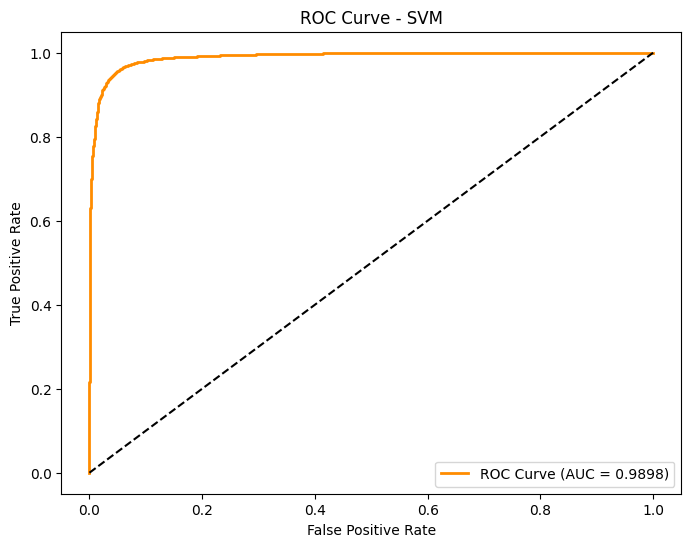

In [ ]:
#SVM - ROC Curve
svm_scores = svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, svm_scores)
roc_auc = auc(fpr, tpr)

#Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

# LSTM

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
710/710 - 704s - 991ms/step - accuracy: 0.5861 - loss: 0.6443 - val_accuracy: 0.6315 - val_loss: 0.5772
Epoch 2/5
710/710 - 724s - 1s/step - accuracy: 0.8204 - loss: 0.4233 - val_accuracy: 0.8396 - val_loss: 0.3362
Epoch 3/5
710/710 - 777s - 1s/step - accuracy: 0.9050 - loss: 0.2567 - val_accuracy: 0.8945 - val_loss: 0.2439
Epoch 4/5
710/710 - 697s - 981ms/step - accuracy: 0.9191 - loss: 0.2185 - val_accuracy: 0.9294 - val_loss: 0.1765
Epoch 5/5
710/710 - 694s - 978ms/step - accuracy: 0.9517 - loss: 0.1387 - val_accuracy: 0.9619 - val_loss: 0.1105

Test Accuracy: 0.9607
395/395 ━━━━━━━━━━━━━━━━━━━━ 63s 158ms/step

              precision    recall  f1-score   support

           0     0.9615    0.9682    0.9649      7017
           1     0.9598    0.9514    0.9556      5594

    accuracy                         0.9607     12611
   macro avg     0.9606    0.9598    0.9602     12611
weighted avg     0.9607    0.9607    0.9607     12611



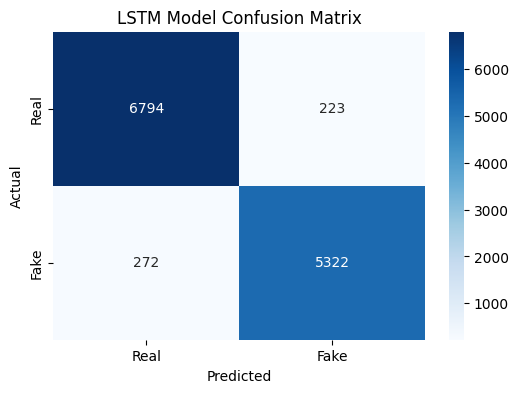

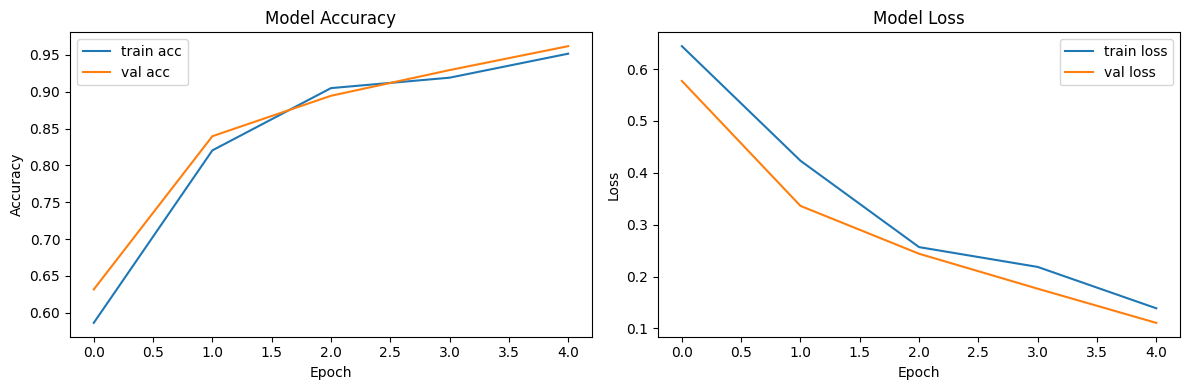

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframe
df = pd.read_csv("/content/drive/MyDrive/cleaned_fake_news_v3.csv")

# Combine title and text (if both available) for better representation
df['content'] = df['title'].astype(str) + " " + df['text'].astype(str)

# Assume `df` is your preprocessed DataFrame with 'content' (text) and 'label' (0 or 1)
texts = df['content'].astype(str).tolist()
labels = df['label'].values

# Tokenize and convert to sequences
VOCAB_SIZE = 10000
MAX_SEQ_LEN = 500
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded, labels, test_size=0.2, random_state=42
)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=MAX_SEQ_LEN),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=2
)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Predictions and Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\n" + classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Model Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 61s 154ms/step


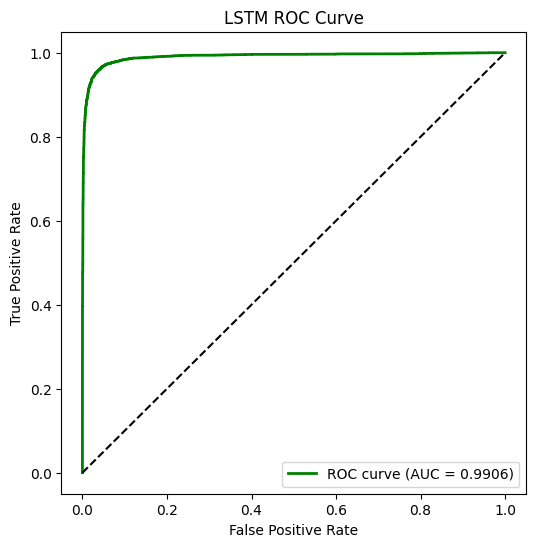

In [ ]:
from sklearn.metrics import roc_curve, auc

#LSTM - ROC Curve
y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

#Plot ROC Curves
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend(loc="lower right")
plt.show()
